## I N T R O D U C T I O N

This note explores and sets up all the building blocks needed to run BAGAP on andicity.
The following main (custom) functions explains the rationale behind the implementation:
<ul>
  <li> Create Population. Each member of the population is created having a string of NVARS bootstrap individuals (drawn from the nBoots=1000 experts).</li>
    <ul>
      <li> </li>
    </ul>
  <li> Crossover. </li>
  <li> Mutation. </li>
  <li> Selection.</li>
  <li> Migration. [Useless, hence not considered for implementation.]</li>
</ul>

#### Customizing the Genetic Algorithm for a Custom Data Type <a href="https://it.mathworks.com/help/gads/examples/custom-data-type-optimization-using-the-genetic-algorithm.html"> [link]</a>
By default, the genetic algorithm solver solves optimization problems based on double and binary string data types. The functions for creation, crossover, and mutation assume the population is a matrix of type double, or logical in the case of binary strings. The genetic algorithm solver can also work on optimization problems involving arbitrary data types. You can use any data structure you like for your population. For example, a custom data type can be specified using a MATLAB® cell array. <b>In order to use ga with a population of type cell array you must provide a <font color="red">creation</font> function, a <font color="red">crossover</font> function, and a <font color="red">mutation</font> function that will work on your data type, e.g., a cell array.</b>

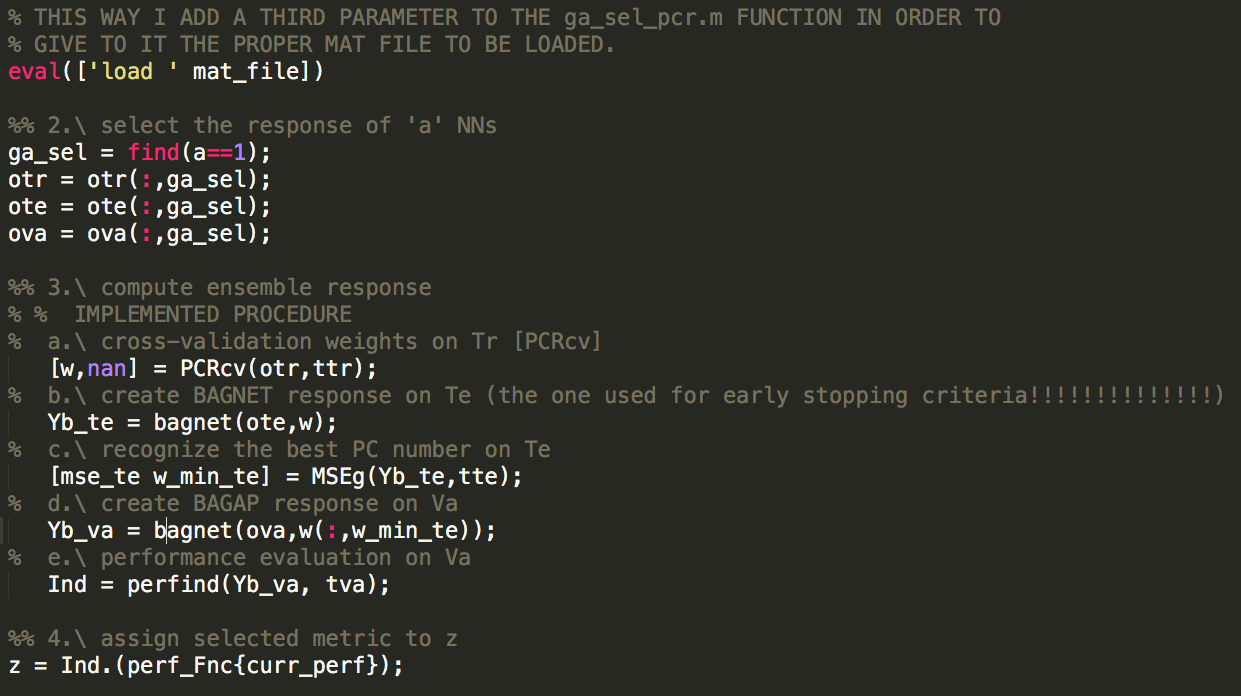

## L O A D

In [17]:
%% P A R s
WDIR                = '~/git/seminars/BAGAP';
cd( WDIR )
name = 'ann1kh2_al05fe_3D__cl_o_r__corr.mat';

%% L O A D
%load( fullfile(WDIR,'data4models.mat'), 'DATA2' )
load( fullfile(WDIR,name) )
%load( fullfile(WDIR,'ann1kh2_al05fe_3D__cl_o_r__corr__SMALL.mat') )

whos

  Name                 Size                 Bytes  Class                      Attributes

  CreateFnc            1x1                     32  function_handle                      
  CrossFnc             1x1                     32  function_handle                      
  CrossFract           1x1                      8  double                               
  FitnessFnc           1x1                     32  function_handle                      
  MutateFnc            1x1                     32  function_handle                      
  Ntest                1x1                      8  double                               
  Ntr                  1x1                      8  double                               
  Nva                  1x1                      8  double                               
  O                    1x1                6880528  struct                               
  P                    1x1                   9082  struct                               
  T                 

## P L O T

#### PREPARE

In [28]:
sclorpt         = name( strfind(name,'__')+2 : strfind(name,'.')-1 );
annResamples    = numel(iPerf_tr);
[R,Q]           = size(x_in);
Ntr             = size(y_sim_tr,2);
Nva             = size(y_sim_va,2);
Nte             = size(y_sim_te,2);
Ntot            = Ntr + Nva + Nte;
testInd         = [trainRec.testInd];
%testInd         = reshape(testInd,Nte,size(testInd,2)/Nte);

% select best case:
[~,iMin]        = min( [iPerf_tr.rmse] );
iMin            = iMin(1);
% select median case:
Med             = median( [iPerf_tr.r] );
[~,iMed]        = min( abs([iPerf_tr.r]-Med) );
iMed            = iMed(1);

In [30]:
size(testInd)

ans =
         129        1000


#### line plot | All & Te | Best & Median

In [42]:
%hold on
%plot( 1:Ntot, target,       '--og', ...
%      1:Ntr, y_sim_tr(iMin,:),'^m',   ...
%      1:Ntr, y_sim_tr(iMed,:),'sb'    )
%plot( testInd(:,iMin), y_sim_tr(iMin,testInd(:,iMin)),'^m','MarkerFaceColor','m' )
%plot( testInd(:,iMed), y_sim_tr(iMed,testInd(:,iMed)),'sb','MarkerFaceColor','b' )
%legend('measurements','Best Case','Median Case')
%hold off

#### boxplot | Tr +Va +Te

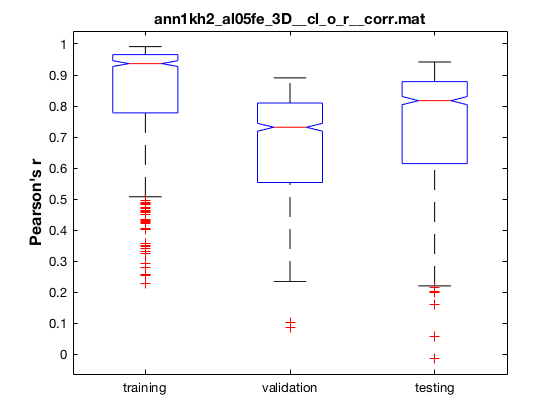

In [44]:
figure(11),
%myTitle = sprintf( '%d random ANNs, S = f(%s,...):\n %d soil layers\n %d covariates', annResamples, sclorpt, Q, R );
%title(myTitle,'FontWeight','b','FontSize',14,'Interpreter','none')

%subplot(131),boxplot( [iPerf_tr.r], 'notch','on' )
%ylabel( {'Pearson''s r';'(training)'},'FontWeight','b','FontSize',12)
%subplot(132),boxplot( [iPerf_tr.r], 'notch','on' )
%ylabel( {'Pearson''s r';'(testing)'},'FontWeight','b','FontSize',12)
%subplot(133),boxplot( [iPerf_tr.r], 'notch','on' )
%ylabel( {'Pearson''s r';'(validation)'},'FontWeight','b','FontSize',12)
group = [ones(Ntot,1),2*ones(Ntot,1),3*ones(Ntot,1)];
bp_lab = {'training','validation','testing'};
boxplot( [[iPerf_tr.r]',[iPerf_va.r]',[iPerf_te.r]'], 'notch','on', 'Labels',bp_lab )
ylabel('Pearson''s r','FontWeight','b','FontSize',12)
title(name)

## P R E P A R E

In [2]:
% simulations:
O.otr           = y_sim_tr';
O.ova           = y_sim_va';
O.ote           = y_sim_te';
% targets:
T.ttr           = ttr';
T.tva           = tva';
T.tte           = tte';

In [3]:
% size of subsets
fprintf(' DATA   [%4s,%4s]\n','rows','cols')
fprintf('--------------------\n')
fprintf(' otr    [%4d,%4d]\n',size(O.otr))
fprintf(' ova    [%4d,%4d]\n',size(O.ova))
fprintf(' ote    [%4d,%4d]\n',size(O.ote))
fprintf(' ttr    [%4d,%4d]\n',size(T.ttr))
fprintf(' tva    [%4d,%4d]\n',size(T.tva))
fprintf(' tte    [%4d,%4d]\n',size(T.tte))
fprintf('--------------------\n')
fprintf('        [%4s,%4s]\n','repl','boot')

 DATA   [rows,cols]
--------------------
 otr    [ 602,1000]
 ova    [ 129,1000]
 ote    [ 129,1000]
 ttr    [ 602,   1]
 tva    [ 129,   1]
 tte    [ 129,   1]
--------------------
        [repl,boot]


#### parameters specific for andicity

In [4]:
rng(14,'twister')

In [5]:
nBoots   = 1000;% 1000 | 
nvars    = 10;  % 50   | 25 / 50 / 75 / 100 % == GenomeLength
popsize  = 100; % 200  | 100 : 100 : 500
maxgen   = 200; % 500  | 250 : 250 : 100*nvars

## F U N C T I O N S
Create and register the three required functions: <font color="red">creation</font>, <font color="red">crossover</font>, and <font color="red">mutation</font>.

#### Create Population

In [6]:
CreateFnc = @(nvars,fitfnc,opt) create_pop_rand(nvars,fitfnc,opt,nBoots);

### R e p r o d u c t i o n:

#### Crossover

In [7]:
% https://it.mathworks.com/help/gads/vary-mutation-and-crossover.html?searchHighlight=ga%20crossover&s_tid=doc_srchtitle
CrossFract = 0.8;
useSorting = true;
CrossFnc = @(parents,options,GenomeLength,FitnessFcn,thisScore,thisPopulation) ...
            crossoversinglepoint_cell(parents,options,GenomeLength,FitnessFcn,thisScore,thisPopulation,useSorting); % *** advised!
%CrossFnc = @crossoverscattered_cell;

% Note: I can use the crossover single point algorithm (adapted to cell array)
%       after sorting the Genome composition of a parent. So, this crossover
%       function can highlight good or bad bootstrap replicates because they
%       belong to low or high index position within the [1,1000] range, where
%       the first is the worst ANN and the 1000th is the best evaluated on Tr.
%       In fact when useSorting=TRUE, the xOverPoint value prunes out the worst
%       performing ANN replicates from both parents to build more performing
%       children in this way (parents are both sorted):
%         e.g. length(parent1)=50; xOverPoint = 41; compl = length(parent1)-xOverPoint = 9;
%          > parent1[ 1 ––> xOverPoint | xOverPoint+1 ––> end]
%          > parent2[ 1 ––> compl | compl+1 ––> end]
%          > child[ xOverPoint+1 ––> end | compl+1 ––> end ]
%
%       BUT REMEMBER TO SORT INPUT BOOTSTRAP ANN REPLICATES IN ASCENDING ORDER 
%       OF ERROR PERFORMANCE (from worst to best performance) BEFORE STARTING
%       Genetic Algorithm analysis.

#### Mutation

In [8]:
mutationRate = 4 / nvars; % 0.08%
MutateFnc = @(parents,options,GenomeLength,FitnessFcn,state,thisScore,thisPopulation)...
             mutationpuntiform_cell(parents,options,GenomeLength,FitnessFcn,state,thisScore,thisPopulation,mutationRate,nBoots);

#### Fitness Evaluation

In [12]:
perf = 2; % 2:rmse, ...
FitnessFnc = @(x) ga_pcr_fitness(x, perf, O, T);

## Options Setup

In [13]:
% do not use gaoptimset but optimoptions
%   |NO| ga_opt = gaoptimset(@ga);
ga_opt = optimoptions(@ga, ...
                        'PopulationType',         'custom',...
                        'InitialPopulationRange', [1;popsize]);

ga_opt = optimoptions(ga_opt, ...
                        'CreationFcn',            CreateFnc, ...
                        'CrossoverFcn',           CrossFnc,...
                        'MutationFcn',            MutateFnc, ...
                        'PopulationSize',         popsize, ...
                        'MaxGenerations',         maxgen,...
                        'MaxStallGenerations',    200,...
                        'UseVectorized',          true,...
                        'UseParallel',            false...
                      );
%                        'PlotFcn',                @my_plot, ...

In [14]:
[x,fval,reason,output] = ga(FitnessFnc,nvars,[],[],[],[],[],[],[],ga_opt);

Optimization terminated: maximum number of generations exceeded.


In [15]:
x,fval,reason,output

x =
  cell
    [10�1 double]
fval =
          0.21704261100684
reason =
     0
output = 
  struct with fields:

      problemtype: 'unconstrained'
         rngstate: [1�1 struct]
      generations: 200
        funccount: 20100
          message: 'Optimization terminated: maximum number of generations...'
    maxconstraint: []


In [ ]:
% OLD FASHIONED ––> to be converted / adapted to the new context:
%ga_opt.PopulationType = 'bitString';% not the type to be used in that case study (maybe also in previuous ones)
%ga_opt.PopInitRange = [0;1];        % ERROR
%ga_opt.PopulationSize = [50];       % ERROR
%ga_opt.InitialPopulation = ;        % ??

%ga_opt.CrossoverFraction = 0.8;     % 
%ga_opt.CrossoverFcn = ;             % 

% migration is useless :: https://it.mathworks.com/help/gads/options-changes-in-r2016a.html?searchHighlight=ga%20migration&s_tid=doc_srchtitle
%ga_opt.MigrationInterval = 20;      % USELESS
%ga_opt.MigrationFraction = 0.25;    % USELESS
%ga_opt.MigrationDirection = 'both'; % USELESS

%ga_opt.Generations = 400;           % 
%ga_opt.StallGenLimit = 25;          % 
%ga_opt.StallTest = 'averageChange'; % ABSENT in optimoptions
%ga_opt.StallTimeLimit = Inf;        % 
%ga_opt.TolFun = 1.0e-06;            % 